# Building a Binary Classification Model in PyTorch

PyTorch library is for deep learning. 
Some applications of deep learning models are to solve regression or classification problems.
In this tutorial, you will discover how to use PyTorch to develop and evaluate neural network models for binary classification problems.

## Outcome

After completing this tutorial, you will know:

- How to load training data and make it available to PyTorch
- How to design and train a neural network
- How to evaluate the performance of a neural network model using k-fold cross validation
- How to run a model in inference mode
- How to create receiver operating characteristics curve for a binary classification model

## Description of the Dataset

The dataset you will use in this tutorial is the [Sonar dataset](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)).

This is a dataset that describes sonar chirp returns bouncing off different services. 
The 60 input variables are the strength of the returns at different angles. 
It is a binary classification problem that requires a model to differentiate rocks from metal cylinders.

You can learn more about this dataset on the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)). 
You can [download the dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data) for free and place it in your working directory with the filename `sonar.csv`.

It is a well-understood dataset. 
All the variables are continuous and generally in the range of 0 to 1. 
The output variable is a string "M" for mine and "R" for rock, which will need to be converted to integers 1 and 0.

A benefit of using this dataset is that it is a standard benchmark problem. 
This means that we have some idea of the expected skill of a good model. 
Using cross-validation, a neural network should be able to achieve a performance of 84% to 88% accuracy.

## Load the Dataset

If you have downloaded the dataset in CSV format and saved it as sonar.csv in the local directory, you can load the dataset using pandas. 
There are 60 input variables (X) and one output variable (y). 
Because the file contains mixed data of strings and numbers, it is easier to read them using pandas rather than other tools such as NumPy.

Data can be read as follows:

In [2]:
import pandas as pd
 
# Read data
data = pd.read_csv("sonar.csv", header=None)
X = data.iloc[:, 0:60]
y = data.iloc[:, 60]

It is a binary classification dataset. 
You would prefer a numeric label over a string label. 
You can do such conversion with LabelEncoder in scikit-learn. 
The LabelEncoder is to map each label to an integer. 
In this case, there are only two labels and they will become 0 and 1.

Using it, you need to first call the fit() function to make it learn what labels are available. 
Then call transform() to do the actual conversion. 
Below is how you use LabelEncoder to convert y from strings into 0 and 1:

In [3]:
from sklearn.preprocessing import LabelEncoder
 
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

You can see the labels using:

In [4]:
print(encoder.classes_)

['M' 'R']


and if you run `print(y)`, you would see the following

In [5]:
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


You see the labels are converted into 0 and 1. 
From the encoder.classes_, you know that 0 means "M" and 1 means "R". 
They are also called the negative and positive classes respectively in the context of binary classification.

Afterward, you should convert them into PyTorch tensors as this is the format a PyTorch model would like to work with.

In [6]:
import torch
 
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

## Creating a Model

Now you're ready for the neural network model.

As you have seen in some previous tutorials, the easiest neural network model is a 3-layer model that has only one hidden layer. 
A deep learning model is usually referring to those with more than one hidden layer. 
All neural network models have parameters called weights. 
The more parameters a model has, heuristically we believe that it is more powerful. 
Should you use a model with fewer layers but more parameters on each layer, or a model with more layers but less parameters each? Let's find out.

A model with more parameters on each layer is called a wider model. 
In this example, the input data has 60 features to predict one binary variable. 
You can assume to make a wide model with one hidden layer of 180 neurons (three times the input features). 
Such model can be built using PyTorch:

In [7]:
import torch.nn as nn
 
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

Because it is a binary classification problem, the output have to be a vector of length 1. 
Then you also want the output to be between 0 and 1 so you can consider that as probability or the model's confidence of prediction that the input corresponds to the "positive" class.

A model with more layer is called a deeper model. 
Considering that the previous model has one layer with 180 neurons, you can try one with three layers of 60 neurons each instead. 
Such model can be built using PyTorch:

In [8]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

You can confirm that these two models are having similar number of parameters, as follows:

In [9]:
# Compare model sizes
model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

11161
11041


There will be all the model's parameters returned by model1.parameters() and each is a PyTorch tensors. 
Then you can reformat each tensor into a vector and count the length of the vector, using x.reshape(-1).shape[0]. 
So the above sum up the total number of parameters in each model.

## Comparing Models with Cross-Validation

Should you use a wide model or a deep model? One way to tell is to use cross-validation to compare them.

It is a technique that, use a "training set" of data to train the model and then use a "test set" of data to see how accurate the model can predict. 
The result from test set is what you should focus on. 
But you do not want to test a model once because if you see an extremely good or bad result, it may be by chance. 
You want to run this process $k$ times with different training and test sets, such that you are ensured that you are comparing the **model design**, not the result of a particular training.

The technique that you can use here is called k-fold cross validation. 
It is to split a larger dataset into $k$ portions and take one portion as the test set while the $k-1$ portions are combined as the training set. 
There are $k$ different such combinations. 
Therefore you can repeat the experiment for $k$ times and take the average result.

In scikit-learn, you have a function for stratified k-fold. 
Stratified means that when the data is split into $k$ portions, the algorithm will look at the labels (i.e., the positive and negative classes in a binary classification problem) to ensure it is split in such a way that each portion contains equal number of either classes.

Running k-fold cross validation is trivial, such as the following:

```python
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = []
for train, test in kfold.split(X, y):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X[train], y[train], X[test], y[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores.append(acc)

# evaluate the model
acc = np.mean(cv_scores)
std = np.std(cv_scores)
print("Model accuracy: %.2f%% (+/- %.2f%%)" % (acc*100, std*100))
```

Simply speaking, you use StratifiedKFold() from scikit-learn to split the dataset. 
This function returns to you the indices. 
Hence you can create the splitted dataset using X[train] and X[test] and named them training set and validation set (so it is not confused with "test set" which will be used later, after we picked our model design). 
You assume to have a function that runs the training loop on a model and give you the accuracy on the validation set. 
You can than find the mean and standard deviation of this score as the performance metric of such model design. 
Note that you need to create a new model every time in the for-loop above because you should not re-train a trained model in the k-fold cross valiation.

The training loop can be defined as follows:

In [12]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
 
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

The training loop above contains the usual elements: The forward pass, the backward pass, and the gradient descent weight updates. 
But it is extended to have an evaluation step after each epoch: You run the model at evaluation mode and check how the model predicts the validation set. 
The accuracy on the validation set is remembered along with the model weight. 
At the end of the training, the best weight is restored to the model and the best accuracy is returned. 
This returned value is the best you ever encountered during the many epochs of training and it is based on the validation set.

Note that you set disable=True in the tqdm above. 
You can set it to False to see the training set loss and accuracy as you progress in the training.

Remind that the goal is to pick the best design and train the model again, which in the training, you want to have an evaluation score so you know what to expect in production. 
Thus you should split the entire dataset you obtained into a training set and test set. 
Then you further split the training set in k-fold cross validation.

With these, here is how you can compare the two model designs: By running k-fold cross validation on each and compare the accuracy:

In [14]:
from sklearn.model_selection import StratifiedKFold, train_test_split
 
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

Accuracy (wide): 0.79
Accuracy (wide): 0.90
Accuracy (wide): 0.86
Accuracy (wide): 0.69
Accuracy (wide): 0.76
Accuracy (deep): 0.86
Accuracy (deep): 0.72
Accuracy (deep): 0.86
Accuracy (deep): 0.83
Accuracy (deep): 0.79
Wide: 80.00% (+/- 7.36%)
Deep: 81.38% (+/- 5.16%)


So you found that the deeper model is better than the wider model, in the sense that the mean accuracy is higher and its standard deviation is lower.

## Retrain the Final Model

Now you know which design to pick, you want to rebuild the model and retrain it. 
Usually in k-fold cross validation, you will use a smaller dataset to make the training faster. 
The final accuracy is not an issue because the gold of k-fold cross validation to to tell which design is better. 
In the final model, you want to provide more data and produce a better model, since this is what you will use in production.

As you already split the data into training and test set, these are what you will use. 
In Python code,

In [15]:
# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

Retrain a deep model
Final model accuracy: 82.54%


You can reuse the model_train() function as it is doing all the required training and validation. 
This is because the training procedure doesn't change for the final model or during k-fold cross validation.

This model is what you can use in production. 
Usually it is unlike training, prediction is one data sample at a time in production. 
The following is how we demonstate using the model for inference by running five samples from the test set:

In [16]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[0.0093 0.0269 0.0217 0.0339 0.0305 0.1172 0.145  0.0638 0.074  0.136
 0.2132 0.3738 0.3738 0.2673 0.2333 0.5367 0.7312 0.7659 0.6271 0.4395
 0.433  0.4326 0.5544 0.736  0.8589 0.8989 0.942  0.9401 0.9379 0.8575
 0.7284 0.67   0.7547 0.8773 0.9919 0.9922 0.9419 0.8388 0.6605 0.4816
 0.2917 0.1769 0.1136 0.0701 0.1578 0.1938 0.1106 0.0693 0.0176 0.0205
 0.0309 0.0212 0.0091 0.0056 0.0086 0.0092 0.007  0.0116 0.006  0.011 ] -> [0.99972063] (expected [1.])
[0.0378 0.0318 0.0423 0.035  0.1787 0.1635 0.0887 0.0817 0.1779 0.2053
 0.3135 0.3118 0.3686 0.3885 0.585  0.7868 0.9739 1.     0.9843 0.861
 0.8443 0.9061 0.5847 0.4033 0.5946 0.6793 0.6389 0.5002 0.5578 0.4831
 0.4729 0.3318 0.3969 0.3894 0.2314 0.1036 0.1312 0.0864 0.2569 0.3179
 0.2649 0.2714 0.1713 0.0584 0.123  0.22   0.2198 0.1074 0.0423 0.0162
 0.0093 0.0046 0.0044 0.0078 0.0102 0.0065 0.0061 0.0062 0.0043 0.0053] -> [0.17926934] (expected [1.])
[0.0208 0.0186 0.0131 0.0211 0.061  0.0613 0.0612 0.0506 0.0989 0.1093
 0.1063 0.117

You run the code under torch.no_grad() context because you sure there's no need to run the optimizer on the result. 
Hence you want to relieve the tensors involved from remembering how the values are computed.

The output of a binary classification neural network is between 0 and 1 (because of the sigmoid function at the end). 
From encoder.classes_, you can see that 0 means "M" and 1 means "R". 
For a value between 0 and 1, you can simply round it to the nearest integer and interpret the 0-1 result, i.e.,

In [17]:
y_pred = model(X_test[i:i+1])
y_pred = y_pred.round() # 0 or 1

or use any other threshold to quantize the value into 0 or 1, i.e.,

In [18]:
threshold = 0.68
y_pred = model(X_test[i:i+1])
y_pred = (y_pred > threshold).float() # 0.0 or 1.0

Indeed, round to the nearest integer is equivalent to using 0.5 as the threshold. 
A good model should be robust to the choice of threshold. 
It is when the model output exactly 0 or 1. 
Otherwise you would prefer a model that seldom report values in the middle but often return values close to 0 or close to 1. 
To see if your model is good, you can use receiver operating characteristic curveÂ (ROC), which is to plot the true positive rate against the false positive rate of the model under various threshold. 
You can make use of scikit-learn and matplotlib to plot the ROC:

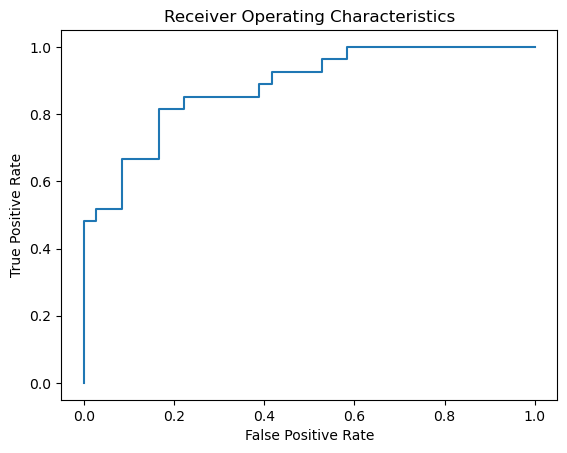

In [19]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
 
with torch.no_grad():
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

You may see the following. 
The curve is always start from the lower left corner and ends at upper right corner. 
The closer the curve to the upper left corner, the better your model is.

## Complete Code

Putting everything together, the following is the complete code of the above:

11161
11041
Accuracy (wide): 0.83
Accuracy (wide): 0.90
Accuracy (wide): 0.83
Accuracy (wide): 0.76
Accuracy (wide): 0.72
Accuracy (deep): 0.83
Accuracy (deep): 0.90
Accuracy (deep): 0.79
Accuracy (deep): 0.86
Accuracy (deep): 0.79
Wide: 80.69% (+/- 6.01%)
Deep: 83.45% (+/- 4.02%)
Retrain a deep model
Final model accuracy: 80.95%
[4.280e-02 5.550e-02 7.080e-02 6.180e-02 1.215e-01 1.524e-01 1.543e-01
 3.910e-02 6.100e-02 1.130e-02 1.255e-01 2.473e-01 3.011e-01 3.747e-01
 4.520e-01 5.392e-01 6.588e-01 7.113e-01 7.602e-01 8.672e-01 8.416e-01
 7.974e-01 8.385e-01 9.317e-01 8.555e-01 6.162e-01 4.139e-01 3.269e-01
 3.108e-01 2.554e-01 3.367e-01 4.465e-01 5.000e-01 5.111e-01 5.194e-01
 4.619e-01 4.234e-01 4.372e-01 4.277e-01 4.433e-01 3.700e-01 3.324e-01
 2.564e-01 2.527e-01 2.137e-01 1.789e-01 1.010e-01 5.280e-02 4.530e-02
 1.180e-02 9.000e-04 1.420e-02 1.790e-02 7.900e-03 6.000e-03 1.310e-02
 8.900e-03 8.400e-03 1.130e-02 4.900e-03] -> [0.11515472] (expected [0.])
[0.0131 0.0068 0.0308 0.03

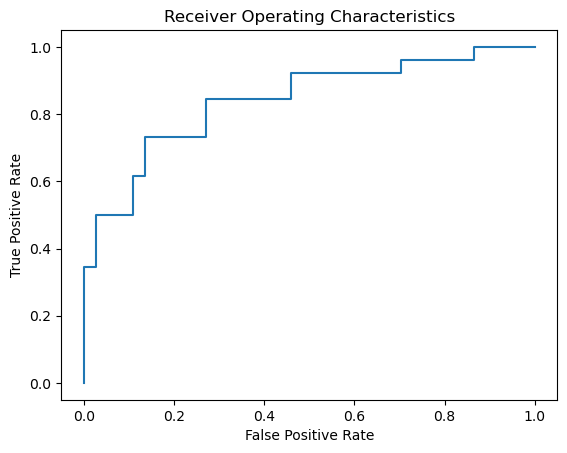

In [20]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
 
# Read data
data = pd.read_csv("sonar.csv", header=None)
X = data.iloc[:, 0:60]
y = data.iloc[:, 60]
 
# Binary encoding of labels
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
 
# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
 
# Define two models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

# Compare model sizes
model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041
 
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc
 
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))
 
# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")
 
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
 
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

## Summary

In this tutorial, you discovered the use of PyTorch to build a binary classification model.

You learned how you can work through a binary classification problem step-by-step with PyTorch, specifically:

- How to load and prepare data for use in PyTorch
- How to create neural network models and use k-fold cross validation to compare them
- How to train a binary classification model and obtain the receiver operating characteristics curve for it